In [15]:
# Import necessary libraries
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load the dataset
imdb_data = load_dataset('imdb', split='train[:1000]')  # Loading only 1000 samples for a toy example

# Define the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Preprocess the data
def encode(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

imdb_data = imdb_data.map(encode, batched=True)

# Format the dataset to PyTorch tensors
imdb_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Found cached dataset imdb (/Users/sinanozdemir/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:

# Define the model
model = BertForSequenceClassification.from_pretrained(
  'bert-base-uncased', num_labels=2)

# Define the training arguments
training_args = TrainingArguments(
  output_dir='./results', 
  num_train_epochs=1, 
  per_device_train_batch_size=4
)

# Define the trainer
trainer = Trainer(model=model, args=training_args, train_dataset=imdb_data)

# Train the model
trainer.train()

# Save the model
model.save_pretrained('./my_bert_model')

Step,Training Loss


In [20]:
from transformers import pipeline

# Define the sentiment analysis pipeline
nlp = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Use the pipeline to predict the sentiment of a new review
review = "The movie was fantastic! I enjoyed every moment of it."
result = nlp(review)

# Print the result
print(f"label: {result[0]['label']}, with score: {round(result[0]['score'], 4)}")


label: LABEL_0, with score: 0.9999


In [1]:
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image


# Load the CIFAR10 dataset using Hugging Face datasets
# Load only the first 1% of the train and test sets
train_dataset = load_dataset("cifar10", split="train[:1%]")
test_dataset = load_dataset("cifar10", split="test[:1%]")

# Define the feature extractor
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# Preprocess the data
def transform(examples):
    # print(examples)
    # Convert to list of PIL Images
    examples['pixel_values'] = feature_extractor(images=examples["img"], return_tensors="pt")["pixel_values"]
    return examples

# Apply the transformations
train_dataset = train_dataset.map(transform, batched=True, batch_size=32).with_format('pt')
test_dataset = test_dataset.map(transform, batched=True, batch_size=32).with_format('pt')

Found cached dataset cifar10 (/Users/sinanozdemir/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Found cached dataset cifar10 (/Users/sinanozdemir/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-5927d15e71112d9a.arrow
Loading cached processed dataset at /Users/sinanozdemir/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-b02a40c9c9a60c75.arrow


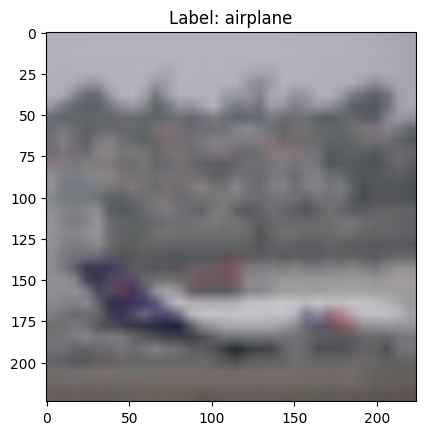

In [3]:

# Assuming `dataset` is already loaded and preprocessed
first_example = train_dataset[0]
image_tensor = first_example["pixel_values"]
label = LABELS[first_example["label"]]

# ViT Feature Extractor normalization values
mean = torch.tensor(feature_extractor.image_mean)
std = torch.tensor(feature_extractor.image_std)

# Unnormalize the image
image_tensor = image_tensor * std[:, None, None] + mean[:, None, None]
image_tensor = image_tensor.clamp(0, 1)

# Convert to PIL image for display
image = to_pil_image(image_tensor)

# Display the image and label
plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from sklearn.metrics import accuracy_score
import numpy as np

# Define the model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224', num_labels=10, ignore_mismatched_sizes=True
)

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model.config.id2label = LABELS
# Define a function for computing metrics
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    load_best_model_at_end=True,
    # Save and evaluate at the end of each epoch
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Evaluate the model
evaluation_results = trainer.evaluate()
print(evaluation_results)


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


{'eval_loss': 2.3310587406158447, 'eval_accuracy': 0.17, 'eval_runtime': 2.404, 'eval_samples_per_second': 41.597, 'eval_steps_per_second': 5.408}


In [7]:
# Train the model
trainer.train()

# Save the model for future use
model.save_pretrained('./my_vit_model')


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.290817,0.920000
2,No log,0.251378,0.950000
3,No log,0.304387,0.940000
4,0.216100,0.310083,0.930000
5,0.216100,0.313031,0.930000


In [11]:
import requests

# URL of the image
image_url = "https://media.istockphoto.com/id/955952680/photo/passengers-commercial-airplane-flying-above-clouds.jpg?s=1024x1024&w=is&k=20&c=khuFYIwkgYzEnSKoatWkjOZkveBIrnvzO_eaafUgBh8="

# Send a GET request to the URL
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Save the image to a file
    with open("plane.jpg", "wb") as file:
        file.write(response.content)
    message = "Image saved successfully."
else:
    message = f"Failed to download the image. Status code: {response.status_code}"

message


'Image saved successfully.'

In [12]:
from PIL import Image
from transformers import ViTFeatureExtractor, ViTForImageClassification, pipeline

# Define the classification pipeline
classification_pipeline = pipeline(
    'image-classification', 
    model=model, 
    feature_extractor=feature_extractor, 
    device=model.device,
)

# Load an image
image = Image.open('plane.jpg')

# Use the pipeline to classify the image
result = classification_pipeline(image)

# Print the result
print(result)


[{'score': 0.9896725416183472, 'label': 'airplane'}, {'score': 0.002388920169323683, 'label': 'ship'}, {'score': 0.0016418549930676818, 'label': 'bird'}, {'score': 0.0011486002476885915, 'label': 'horse'}, {'score': 0.0011388490675017238, 'label': 'cat'}]


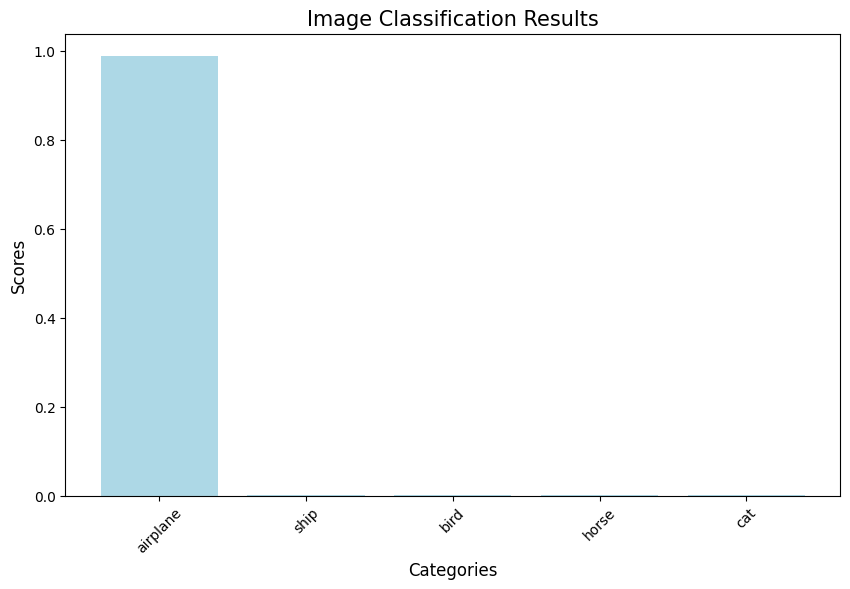

In [13]:

# Extracting labels and scores for plotting
labels = [res["label"] for res in result]
scores = [res["score"] for res in result]

# Creating a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, scores, color='lightblue')
plt.xlabel('Categories', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Image Classification Results', fontsize=15)
plt.xticks(rotation=45)
plt.show()


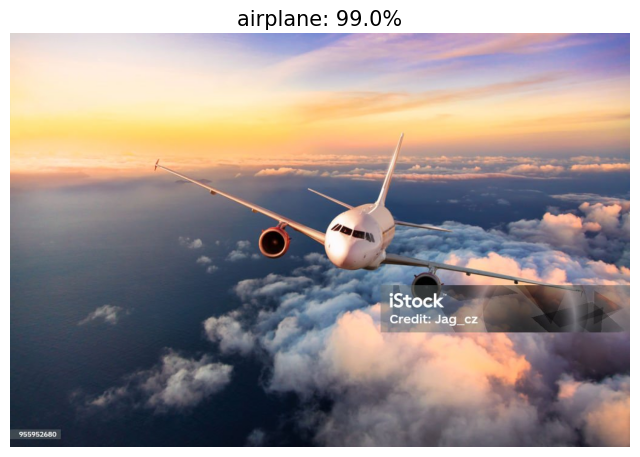

In [14]:
# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers

# Add the top classification result as the title
# Assuming the top result is the most relevant
top_result = result[0]
plt.title(f"{top_result['label']}: {top_result['score'] * 100:.1f}%", fontsize=15)

# Show the plot
plt.show()
